In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import sys, os

import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [101]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [328]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)

## Load in selection function

In [390]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/StanOutput/'

In [391]:
import selectionfunctions.hammer as hammer
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

In [392]:
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

In [393]:
lmax = 100
M = 85
C = 1
lengthscale=0.3

nside=64
run_name = f"lmax{lmax}_nside{nside}_M{M}_C{C}_l{lengthscale}"
map_fname = run_name + "_results.h5"

ast_sf = hammer.hammer(map_fname=map_fname, nside=128, C=C, M=M, 
                       spherical_harmonics_directory='/data/asfe2/Projects/astrometry/SphericalHarmonics/')

Loading auxilliary data ...
t = 0.748 s
  auxilliary:   0.158 s
          sf:   0.000 s
interpolator:   0.590 s


In [402]:
g = [16.1,18.1,20.1]
prob_selection = np.zeros((3,hp.nside2npix(128)))
for i in range(3):
    ra, dec = hp.pix2ang(128,np.arange(hp.nside2npix(128)),nest=True, lonlat=True)
    coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g[i]*np.ones(ra.shape)})

    prob_selection[i] = ast_sf(coords, chunksize=10000)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

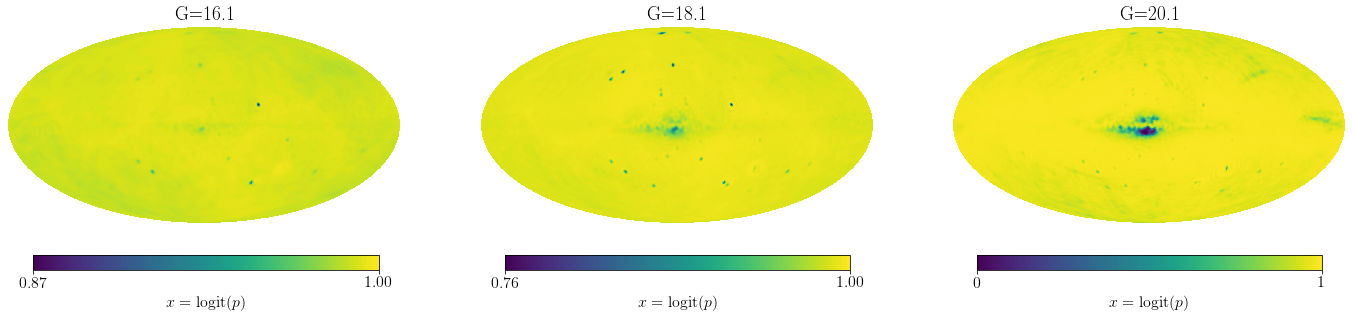

In [287]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
for i in range(3):
    plt.sca(axes[i])
    minmax = [np.round(np.min(prob_selection[i]), decimals=2), np.round(np.max(prob_selection[i]), decimals=2)]
    hp.mollview(prob_selection[i], nest=True, min=minmax[0], max=minmax[1], cbar=False, notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='viridis', hold=True, unit=r'$p$', xsize=2000)
    
    ax = fig.add_axes([i*0.273+0.14, 0.1, 0.2, 0.04]); 
    norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
    im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
    cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[1]])
    cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=16)
    
plt.savefig('figs/%s_p_3hpx.png' % run_name, bbox_inches='tight', dpi=200)

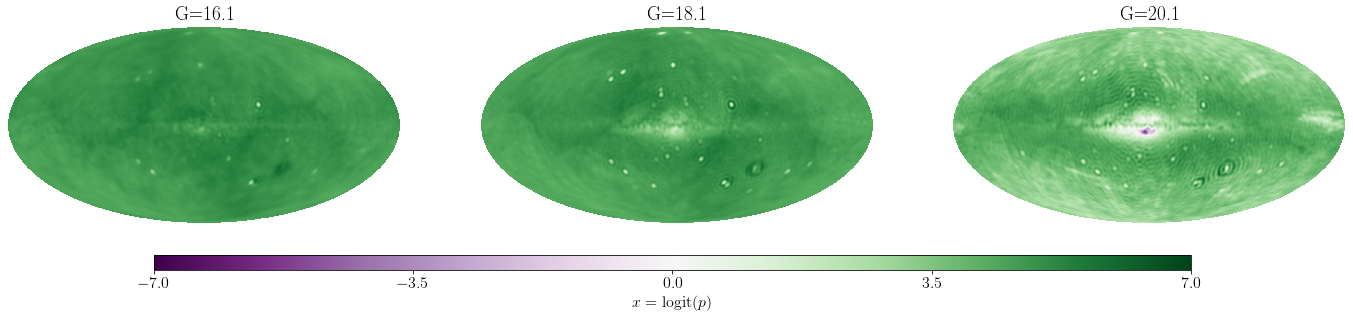

In [403]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    hp.mollview(logit(prob_selection[i]), nest=True, min=minmax[0],max=minmax[1], notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.1, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[0]/2, 0., minmax[1]/2, minmax[1]])
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=16)

plt.savefig('figs/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Beta distribution tests of Comparison

In [394]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [395]:
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=3)
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=3)
    M_bins = hf['magbins'][...]
M_bins = np.linspace(M_bins[0], M_bins[-1], M+1)
print("Mag bins:", M_bins)

box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])

Mag bins: [ 5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2
 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.
 16.2 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8
 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6
 21.8 22. ]


In [371]:
g = [16.1,18.1,20.1]

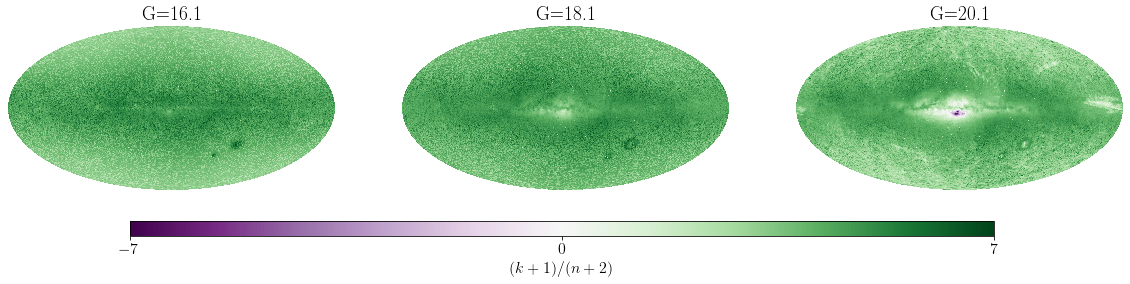

In [381]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    expected = (box['k'][g_idx,0]+1)/(box['n'][g_idx,0]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=16)

plt.savefig('figs/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Load in full pixel selection function

In [28]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]
    sf_box['alm'] = f['a'][...]
    sf_box['Mlim'] = f['Mlim'][...]
    sf_box['Clim'] = f['Clim'][...]

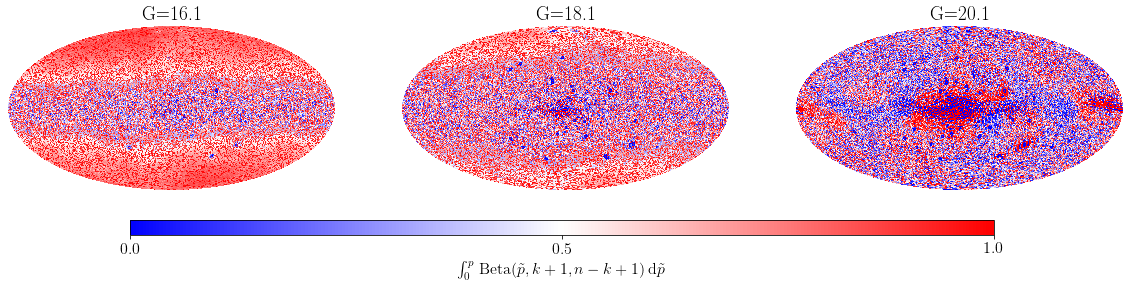

In [384]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    alpha = box['k'][g_idx,0]+1
    beta = box['n'][g_idx,0]-box['k'][g_idx,0]+1
    pvals = scipy.stats.beta.cdf(expit(sf_box['x'][g_idx,0]), alpha, beta)
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$\int_0^p\, \mathrm{Beta}(\tilde{p}, k+1, n-k+1) \,\mathrm{d}\tilde{p}$', fontsize=16)

plt.savefig('figs/%s_pval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

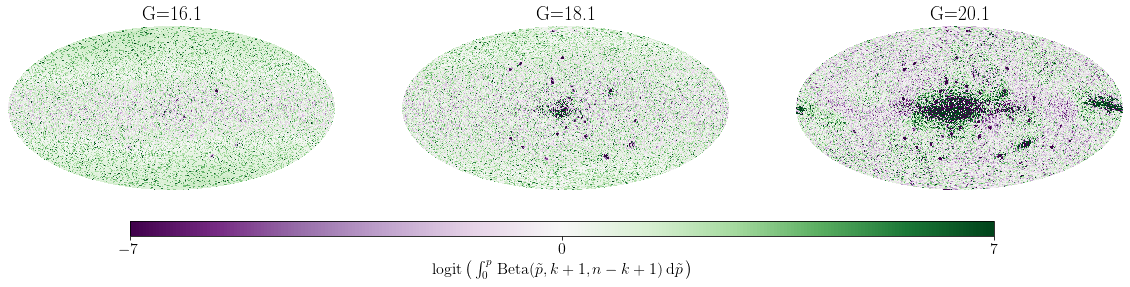

In [385]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    alpha = box['k'][g_idx,0]+1
    beta = box['n'][g_idx,0]-box['k'][g_idx,0]+1
    pvals = scipy.stats.beta.cdf(expit(sf_box['x'][g_idx,0]), alpha, beta)
    #pvals[box['n'][g_idx,0]<5]=np.nan
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,\int_0^p\, \mathrm{Beta}(\tilde{p}, k+1, n-k+1) \,\mathrm{d}\tilde{p}\,\right)$', fontsize=16)

plt.savefig('figs/%s_logit-pval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

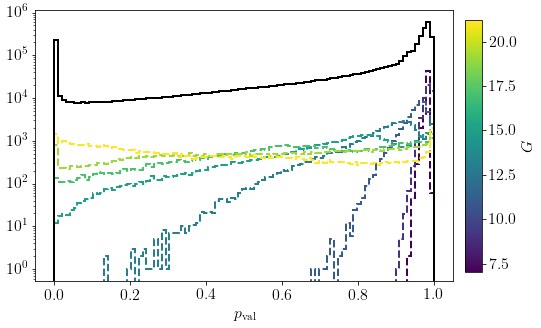

In [386]:
g = np.arange(7.1,21.2,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    alpha = box['k'][g_idx,0]+1
    beta = box['n'][g_idx,0]-box['k'][g_idx,0]+1
    pvals = scipy.stats.beta.cdf(expit(sf_box['x'][g_idx,0]), alpha, beta)
    plt.hist(pvals, bins=np.linspace(0,1,100), label='G=%.1f'%g[i], histtype='step',
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    

alpha = box['k']+1
beta = box['n']-box['k']+1
pvals = scipy.stats.beta.cdf(expit(sf_box['x']), box['k']+1, box['n']-box['k']+1)
plt.hist(pvals.flatten(), bins=np.linspace(0,1,100), label='G=%.1f'%g[i], histtype='step',
        color='k', linewidth=2)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_pval_hist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

In [368]:
plt.savefig?

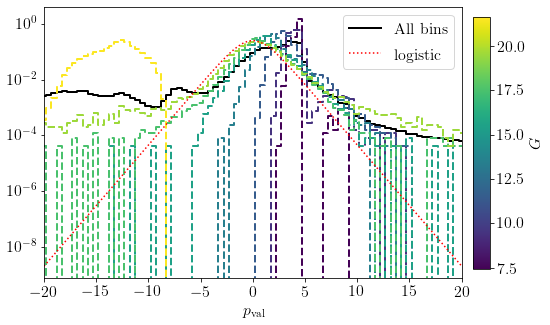

In [389]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

alpha = box['k']+1
beta = box['n']-box['k']+1
pvals = scipy.stats.beta.cdf(expit(sf_box['x']), box['k']+1, box['n']-box['k']+1)

minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)

plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1
for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    alpha = box['k'][g_idx,0]+1
    beta = box['n'][g_idx,0]-box['k'][g_idx,0]+1
    pvals = scipy.stats.beta.cdf(expit(sf_box['x'][g_idx,0]), alpha, beta)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)
    
plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper right')


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_pval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

In [173]:
np.sum(pvals>0.9)/len(pvals), np.sum(pvals<0.1)/len(pvals)

(0.17238362630208334, 0.13824462890625)

## P-value of k

In [390]:
g = [16.1,18.5,20.9]

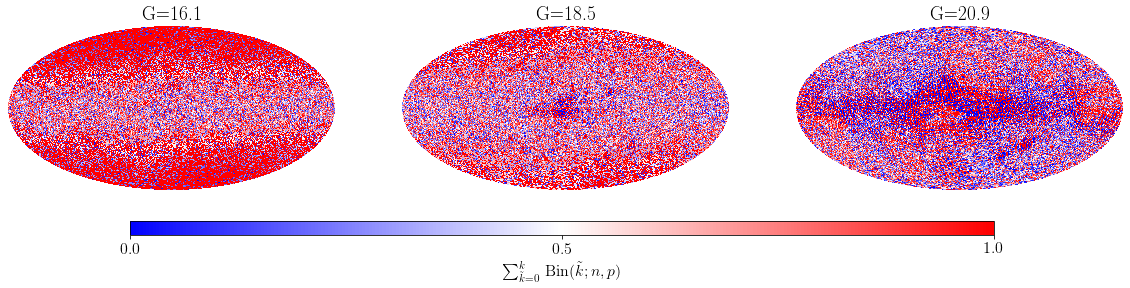

In [391]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pvals = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$\sum_{\tilde{k}=0}^k\, \mathrm{Bin}(\tilde{k}; n,p)$', fontsize=16)

plt.savefig('figs/%s_binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

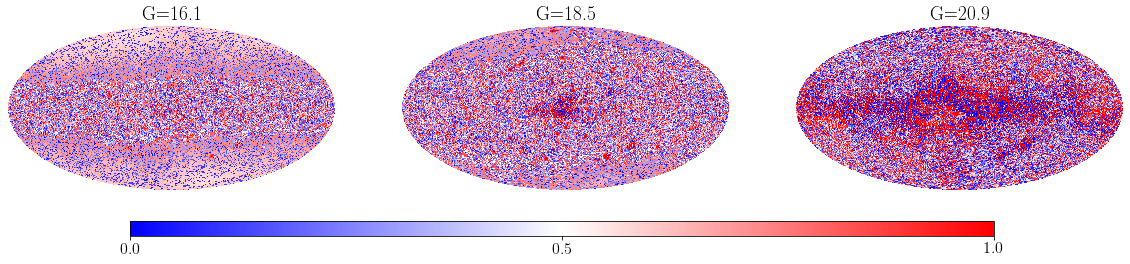

In [393]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pvals = (scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0])) +\
             scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0])))/2
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
#cbar.set_label(r'$\sum_{\tilde{k}=0}^k\, \mathrm{Bin}(\tilde{k}; n,p)$', fontsize=16

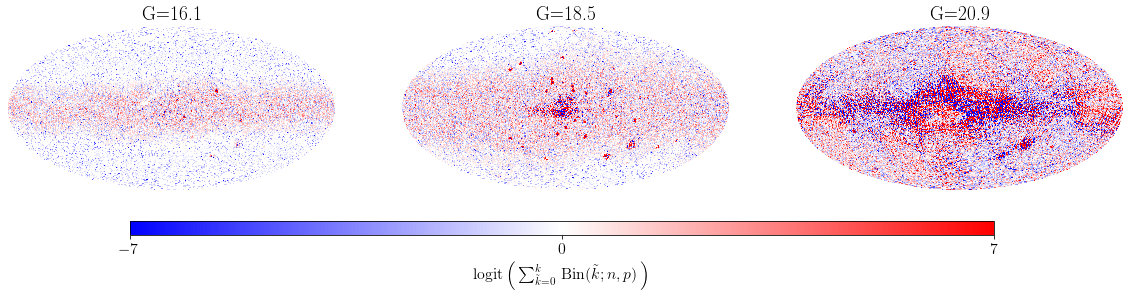

In [394]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pvals = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,\sum_{\tilde{k}=0}^k\, \mathrm{Bin}(\tilde{k}; n,p)\,\right)$', fontsize=16)

plt.savefig('figs/%s_logit-binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

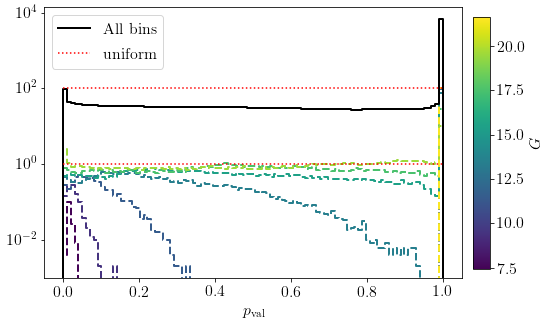

In [397]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pvals = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
#     pvals = (scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))+\
#              scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0])))/2
    plothist(pvals, bins=np.linspace(0,1,100), density=True,
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    
    
pvals = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
# pvals = (scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))+\
#          scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x'])))/2
plothist(pvals.flatten(), bins=np.linspace(0,1,100), label='All bins', 
        color='k', linewidth=2, density=True, count=len(pvals.flatten())/100)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)


plt.plot([0,1], [1,1], ':r', label='uniform')
plt.plot([0,1], [100,100], ':r')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_binompval_hist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

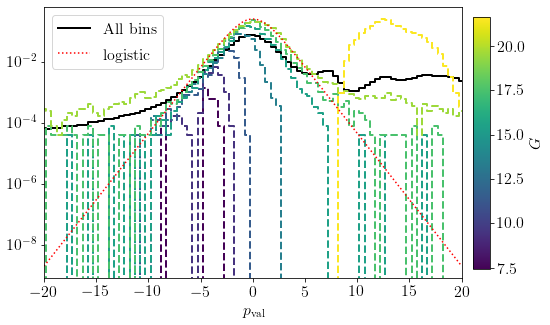

In [396]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

pvals = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
# pvals = (scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))+\
#          scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x'])))/2
minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)
    
pvals[pvals==0.] = expit(minmax[0]+0.05); pvals[pvals==1.] = expit(minmax[1]-0.05)
plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pvals = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
#     pvals = (scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))+
#             scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0])))/2
    pvals[logit(pvals)<minmax[0]] = expit(minmax[0]+0.05); 
    pvals[logit(pvals)>minmax[1]] = expit(minmax[1]-0.05)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

## Two-tail test

In [308]:
g = [16.1,18.1,20.1]

In [353]:
n=2
p=0.5
k = scipy.stats.binom.rvs(n,p, size=10000)

In [355]:
np.unique(k), np.unique((scipy.stats.binom.cdf(k, n,p)+scipy.stats.binom.cdf(k-1, n,p))/2)

(array([0, 1, 2]), array([0.125, 0.5  , 0.875]))

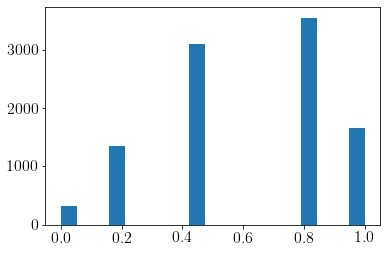

In [347]:
plt.hist(scipy.stats.binom.cdf(k, n,p), bins=np.linspace(0,1,20));

In [345]:
scipy.stats.binom.cdf(-1, n,p)

0.0

In [313]:
scipy.stats.binom_test?
#(box['k'][g_idx,0], box['n'][g_idx,0], 0.5)

In [317]:
%time [scipy.stats.binom_test(box['k'][g_idx,0][ii], box['n'][g_idx,0][ii], \
                              expit(sf_box['x'][g_idx,0])[ii], alternative='two-sided') for ii in range(1000)]

CPU times: user 1.73 s, sys: 8 ms, total: 1.74 s
Wall time: 1.83 s


[0.26923571969107124,
 0.058454272502488136,
 0.1836899381758548,
 1.0,
 1.0,
 1.0,
 0.3164361660764185,
 1.0,
 0.273943177312926,
 1.0,
 1.0,
 1.0,
 0.04320590963299323,
 1.0,
 0.2117657916891581,
 0.324497061269566,
 0.3253953943296852,
 0.3430205588285147,
 1.0,
 1.0,
 0.41641790630874365,
 0.0076168848612691315,
 0.3248520116913165,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0753379102116169,
 1.0,
 0.3523144137924563,
 0.23558671441226472,
 0.3314857922149845,
 1.0,
 0.32777088734605675,
 1.0,
 1.0,
 0.24442177808091867,
 0.4075637650820994,
 0.26143920593672915,
 1.0,
 0.35537664263764523,
 1.0,
 1.0,
 0.044240695515548885,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.3322382933128937,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.25253670414531215,
 0.33354853631833886,
 1.0,
 0.0719813675435396,
 0.25736058732164774,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.3814683941507146,
 1.0,
 0.2825364503918103,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0756865705586751,
 1.0,
 1.0,
 1.0,
 0.37151936036483785,
 1.0,
 1.0,
 0.36

ValueError: Incorrect length for x.

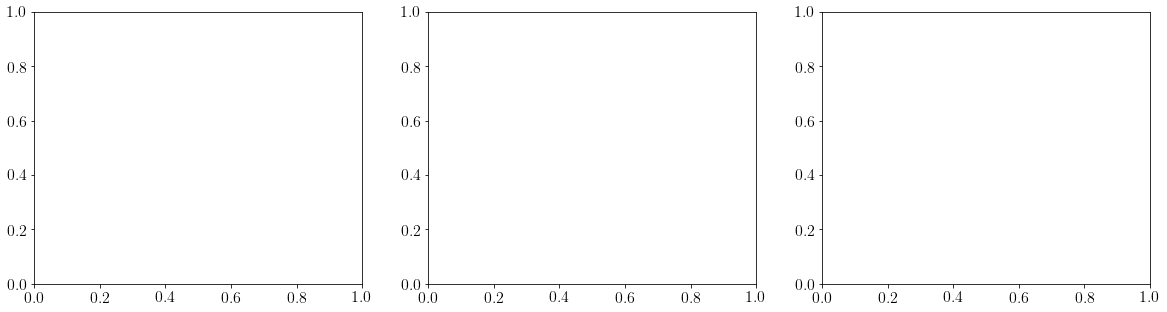

In [309]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pvals = scipy.stats.binom_test(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$\sum_{\tilde{k}=0}^k\, \mathrm{Bin}(\tilde{k}; n,p)$', fontsize=16)

#plt.savefig('figs/%s_binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200)

# Magnitude distribution

In [266]:
area = hp.nside2pixarea(nside) * 180/np.pi**2

sd_target = np.logspace(5 + 2./3, 8 + 1./3, 9)

hpx = np.zeros(len(sd_target), dtype=int)
order = np.argsort(np.sum(box['n'], axis=(0,1)))
for i, sd in enumerate(sd_target):
    nth = np.sum(np.sum(box['n'], axis=(0,1))/area<sd)
    hpx[i] = order[nth]
    
source_density = np.sum(box['n'], axis=(0,1))[hpx]/area

In [268]:
ra, dec = hp.pix2ang(nside, hpx, nest=True, lonlat=True)

g = np.linspace(5,22,500)

rr, gg = np.meshgrid(ra, g)
dd, gg = np.meshgrid(dec, g)

prob_selection = np.zeros((len(ra), g.shape[0]))
coords = Source(rr*units.deg, dd*units.deg, frame='icrs', photometry={'gaia_g':gg})

ast_sf._g_min = np.min(g)
ast_sf._g_max = np.max(g)
prob_selection = ast_sf(coords, chunksize=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

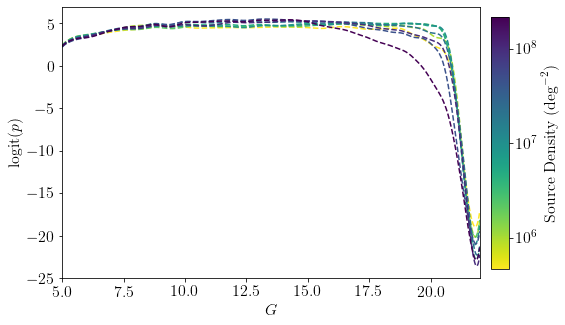

In [363]:
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis_r
logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

for i, sd in enumerate(source_density):
    plt.plot(g, logit(prob_selection[:,i]), '--', color=cmap((np.log10(sd)-logsd_min)/(logsd_max-logsd_min)))
    
plt.xlabel(r'$G$'); plt.ylabel(r'$\mathrm{logit}(p)$')
plt.xlim(np.min(g), np.max(g))

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=sd_target[0], vmax=sd_target[-1],
                   ticks=10**(np.arange(5,9)), tick_labels=[r'$10^%d$' % i for i in np.arange(5,9)] )

cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$', fontsize=16)

plt.savefig('figs/%s_x-vs-mag_sd.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

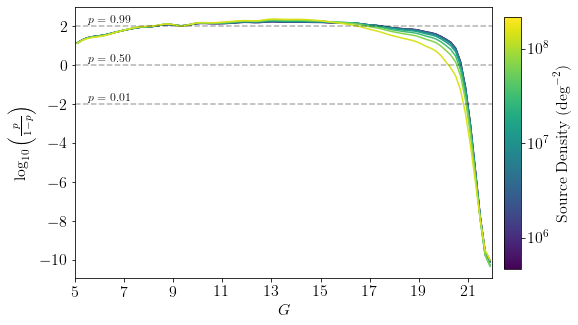

In [453]:
sd_bins = np.logspace(5 + 2./3, 8 + 1./3, 9)
source_count = np.sum(box['n'], axis=(0,1))
source_density = source_count/area

cmap=cm.viridis

fig, ax = plt.subplots(1,1,figsize=(8,5))
for i, sd in enumerate(sd_bins[:-1]):
    pix = source_density>sd_bins[i]
    
    sd = np.sqrt(sd_bins[i]*sd_bins[i+1])
    
    mean = np.sum(sf_box['x'][:,0,:].T[pix] .T* source_count[pix], axis=1) /np.sum(source_count[pix])
    plt.plot(Mcenters, mean / np.log(10),
            c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))
    
plt.xlabel(r'$G$'); plt.ylabel(r'$\mathrm{log}_{10}\left(\frac{p}{1-p}\right)$')
plt.xlim(np.min(g), np.max(g))
ax.set_xticks(np.arange(5,21.1,2.))

for p in [1e-2,0.5,1-1e-2]:
    plt.plot([np.min(g), np.max(g)], [np.log10(p/(1-p)), np.log10(p/(1-p))], '--k', alpha=0.3)
    if p>0.005: plt.text(5.5, np.log10(p/(1-p))+0.2, r'$p = {:.2f}$'.format(p), fontsize=12)
    else: plt.text(5.5, np.log10(p/(1-p))+0.2, r'$10^{%d}$' % np.log10(p), fontsize=12)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=sd_bins[0], vmax=sd_bins[-1],
                   ticks=10**(np.arange(5,9)), tick_labels=[r'$10^%d$' % i for i in np.arange(5,9)] )

cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$', fontsize=16)

plt.savefig('figs/%s_x-vs-mag_meansd.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

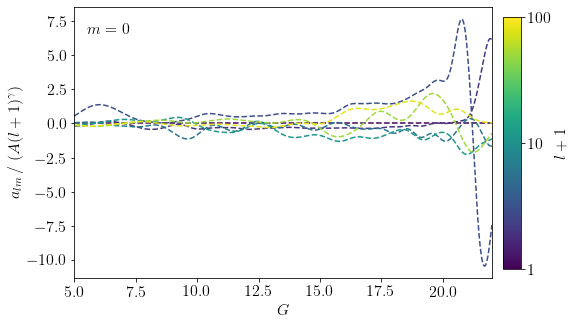

In [376]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

cmap = cm.viridis
logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

l_vals = [0,1,2,5,10,50,80]#,100]
sigma = [-0.81489922, -2.55429039]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(l_vals),sigma[1]))

alm = ast_sf._get_alm(g, np.zeros(len(g)))
for i, _l in enumerate(l_vals):
    idx = np.argwhere((ast_sf._l==_l)&(ast_sf._m==0))[0,0]
    plt.plot(g, alm[idx]/prior_std[i], '--', color=cmap((np.log10(_l+1)-0)/(2-0)))

ylim = ax.get_ylim()
plt.text(5.5, (ylim[1]-ylim[0])*0.9 + ylim[0], r"$m=0$")
    
plt.xlabel(r'$G$'); plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')
plt.xlim(np.min(g), np.max(g))

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=1, vmax=100,
                   ticks=[1,10,100], tick_labels=['1','10','100'] )

cbar.set_label(r'$l+1$', fontsize=16)

plt.savefig('figs/%s_alm-vs-mag_l.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

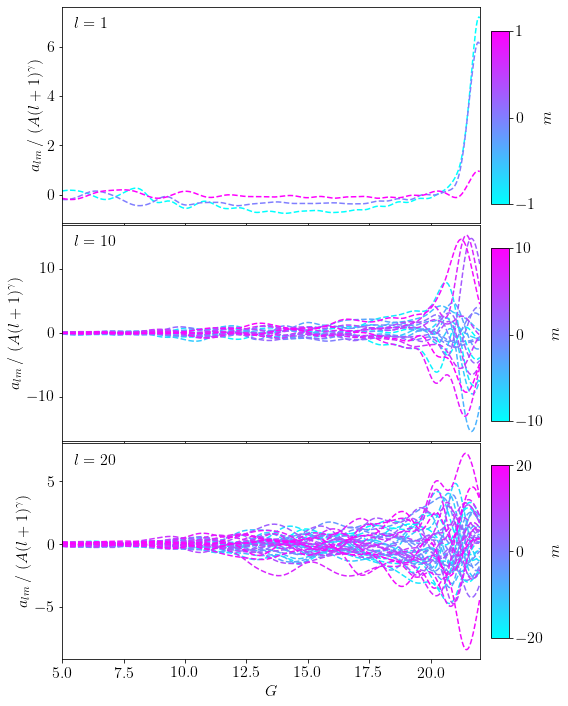

In [370]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.cool
logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

l_vals = [1, 10, 20]#,100]
sigma = [-0.81489922, -2.55429039]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(l_vals),sigma[1]))

alm = ast_sf._get_alm(g, np.zeros(len(g)))

for i, _l in enumerate(l_vals):
    plt.sca(axes[i])
    for _m in range(-_l, _l+1):
        idx = np.argwhere((ast_sf._l==_l)&(ast_sf._m==_m))[0,0]
        plt.plot(g, alm[idx]/prior_std[i], '--', color=cmap((_m+_l)/(2*_l)))
        
    plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(5.5, (ylim[1]-ylim[0])*0.9 + ylim[0], r"$l=%d$" % _l)
    
    # Adding cbar axes to subplots
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15+(2-i)*0.251, 0.03, 0.2])
    norm = matplotlib.colors.Normalize(vmin=-_l,vmax=_l)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    im.set_array([])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[-_l,0,_l])
    cbar.set_label(r'$m$', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/%s_alm-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [315]:
import sys, h5py, numpy as np, scipy.stats, healpy as hp, tqdm

sys.path.append('../SelectionFunctionHammer')
from SelectionFunctionHammer import Hammer

In [ ]:
eps=1e-10

lmax = 20
lengthscale = 0.3

M_bins = np.arange(10,21.1,1)
M = M_bins.shape[0]-1
C = 1
nside=32

nside_original = 128
resize = int((nside_original/nside)**2+0.1)

# Load in n,k data in magnitude-hpx bins
box={}; nside_original = 128
box['n']=np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int)
box['k']=np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int)
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_hpx10.h', 'r') as hf:
    for i, mag in tqdm.tqdm(enumerate(hf['magval']), total=len(hf['magval'])):
        if (mag+eps<M_bins[0])|(mag+eps>M_bins[-1]): continue
        hpx = hf[str(i)]['hpx'][...]//resize
        M_idx = np.sum(M_bins<mag+eps).astype(int) - 1
        box['n'][M_idx,0] = scipy.stats.binned_statistic(hpx, hf[str(i)]['n'][...],
                                                     bins=np.arange(hp.nside2npix(nside)+1)-0.5,
                                                     statistic='sum').statistic.astype(int)
        box['k'][M_idx,0] = scipy.stats.binned_statistic(hpx, hf[str(i)]['k_ast'][...],
                                                     bins=np.arange(hp.nside2npix(nside)+1)-0.5,
                                                     statistic='sum').statistic.astype(int)
lengthscale_m = lengthscale/(M_bins[1]-M_bins[0])
lengthscale_c = 1.

In [317]:
# Import hammer
hammer = Hammer(k = box['k'],
                n = box['n'],
                axes = ['magnitude','colour','position'],
                nest = True,
                lmax = lmax,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                file_root = f"lmax{lmax}_nside{nside}_M{M}_C{C}_l{lengthscale}",
                 spherical_harmonics_directory='/data/asfe2/Projects/astrometry/SphericalHarmonics/',
               stan_model_directory='../SelectionFunctionHammer/StanModels')

 10%|▉         | 42/441 [00:00<00:00, 419.32it/s]

Spherical harmonic file does not exist, generating...


100%|██████████| 441/441 [00:02<00:00, 188.05it/s]
INFO:cmdstanpy:compiling stan program, exe file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionHammer/StanModels/magnitude_colour_position_sparse
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None


Spherical harmonic file loaded
11 11
1 1


INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionHammer/StanModels/magnitude_colour_position_sparse


82.64% sparsity
0.00% sparsity


In [320]:
hammer._lower[0]

440

In [331]:
ast_sf._l[-10:]

array([ 97,  98,  99, 100,  98,  99, 100,  99, 100, 100], dtype=uint32)

In [321]:
hammer._l

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 13, 14, 15, 16, 17, 18, 19, 20, 14,
       15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20, 16, 17, 18, 19, 20,
       17, 18, 19, 20, 18

In [318]:
hammer.sigma

array([0.66534498, 0.27452877, 0.16356628, 0.11327364, 0.08518452,
       0.06748927, 0.05542861, 0.04673797, 0.04021061, 0.03514809,
       0.03111983, 0.02784683, 0.02514082, 0.02287046, 0.02094149,
       0.01928461, 0.01784781, 0.01659135, 0.01548435, 0.01450249,
       0.01362639, 0.27452877, 0.16356628, 0.11327364, 0.08518452,
       0.06748927, 0.05542861, 0.04673797, 0.04021061, 0.03514809,
       0.03111983, 0.02784683, 0.02514082, 0.02287046, 0.02094149,
       0.01928461, 0.01784781, 0.01659135, 0.01548435, 0.01450249,
       0.01362639, 0.16356628, 0.11327364, 0.08518452, 0.06748927,
       0.05542861, 0.04673797, 0.04021061, 0.03514809, 0.03111983,
       0.02784683, 0.02514082, 0.02287046, 0.02094149, 0.01928461,
       0.01784781, 0.01659135, 0.01548435, 0.01450249, 0.01362639,
       0.11327364, 0.08518452, 0.06748927, 0.05542861, 0.04673797,
       0.04021061, 0.03514809, 0.03111983, 0.02784683, 0.02514082,
       0.02287046, 0.02094149, 0.01928461, 0.01784781, 0.01659